<a href="https://colab.research.google.com/github/odedgolden/Affective-Computing/blob/master/RAVDESS_Emotion_Detection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
should_reset = False
should_install_torch = False
try:
  import torchaudio
except ImportError:
  should_install_torch = True

In [2]:
if should_install_torch:
  print("torchaudio not installed, installing torch again...")
  !pip3 uninstall -y torch torchvision
  !sudo apt install libavdevice-dev libavfilter-dev
  !pip3 install torch torchvision torchaudio av -U

torchaudio not installed, installing torch again...
Uninstalling torch-1.1.0:
  Successfully uninstalled torch-1.1.0
Uninstalling torchvision-0.3.0:
  Successfully uninstalled torchvision-0.3.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpostproc-dev
The following NEW packages will be installed:
  libavdevice-dev libavfilter-dev libpostproc-dev
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,154 kB of archives.
After this operation, 5,445 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libpostproc-dev amd64 7:3.4.6-0ubuntu0.18.04.1 [51.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavfilter-dev amd64 7:3.4.6-0ubuntu0.18.04.1 [1,016 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavdevice-dev amd64 7:3.4.6-0ubuntu0.18.04.1 [87.2 k

In [3]:
# Basic Stuff
import numpy as np
import pandas as pd
from time import time, ctime
import random

# Deep Learning Stuff
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchaudio

# Visualization Stuff
import matplotlib.pyplot as plt
from IPython.display import Audio, HTML
import seaborn as sns
sns.set(style="darkgrid")

# Signal Processing Stuff
import av

# Drive Stuff
import urllib.request
import zipfile
import sys
import os
import pickle
import gc
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Constants

In [0]:
root = '/content/drive/My Drive/Colab Notebooks/Research/'
RAVDESS_DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/'
RAVDESS_BASE_URL = 'https://zenodo.org/record/1188976/files/'

RAVEDESS_VIDEO_SONG_FILE_NAME_TEMPLATE = 'Video_Song_Actor_'
RAVEDESS_VIDEO_SPEECH_FILE_NAME_TEMPLATE = 'Video_Speech_Actor_'

FILE_SUFFIX = '.zip'

RAVEDESS_AUDIO_FILE_NAME_SONG = 'Audio_Song_Actors_01-24.zip'
RAVEDESS_AUDIO_FILE_NAME_SPEECH = 'Audio_Speech_Actors_01-24.zip'

In [0]:
# !mkdir '/content/drive/My Drive/Colab Notebooks/Research/RAVDESS'
if should_reset:
  !rm -rf '/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/'*
  !ls '/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/'

#Download RAVDESS Data

In [0]:
def save_obj(obj, name ):
    with open(root + 'obj/' + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
  if os.path.isfile(root + 'obj/' + name + '.pkl'):
    with open(root + 'obj/' + name + '.pkl', 'rb') as f:
          return pickle.load(f)

##Audio Data

In [0]:
if should_reset:
  try:
    urllib.request.urlretrieve(RAVDESS_BASE_URL+RAVEDESS_AUDIO_FILE_NAME_SONG, RAVDESS_DRIVE_DIR+RAVEDESS_AUDIO_FILE_NAME_SONG)
    print('Extracting: '+RAVDESS_DRIVE_DIR+RAVEDESS_AUDIO_FILE_NAME_SONG)

    with zipfile.ZipFile(RAVDESS_DRIVE_DIR+RAVEDESS_AUDIO_FILE_NAME_SONG, 'r') as zip_ref:
      zip_ref.extractall(RAVDESS_DRIVE_DIR+'AUDIO/SONG')
      zip_ref.close()
  except:
    print("An exception occurred: "+str(sys.exc_info()))

In [0]:
if should_reset:
  try:
    urllib.request.urlretrieve(RAVDESS_BASE_URL+RAVEDESS_AUDIO_FILE_NAME_SPEECH, RAVDESS_DRIVE_DIR+RAVEDESS_AUDIO_FILE_NAME_SPEECH)
    print('Extracting: '+RAVDESS_DRIVE_DIR+RAVEDESS_AUDIO_FILE_NAME_SPEECH)

    with zipfile.ZipFile(RAVDESS_DRIVE_DIR+RAVEDESS_AUDIO_FILE_NAME_SPEECH, 'r') as zip_ref:
      zip_ref.extractall(RAVDESS_DRIVE_DIR+'AUDIO/SPEECH')
      zip_ref.close()
  except:
    print("An exception occurred: "+str(sys.exc_info()))

##Video Data

In [0]:
indices = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','19','20','21','22','23','24'] 
if should_reset:
  for i in range(len(indices)):
    try:
      file = RAVEDESS_VIDEO_SONG_FILE_NAME_TEMPLATE + indices[i] + '.zip'
      print('Downloading: '+RAVDESS_BASE_URL+file)
      urllib.request.urlretrieve(RAVDESS_BASE_URL+file, RAVDESS_DRIVE_DIR+file)
      print('Extracting: '+RAVDESS_DRIVE_DIR+file)

      with zipfile.ZipFile(RAVDESS_DRIVE_DIR+file, 'r') as zip_ref:
        zip_ref.extractall(RAVDESS_DRIVE_DIR+'VIDEO/SONG')
        zip_ref.close()
      print('Extracted to: '+RAVDESS_DRIVE_DIR+'VIDEO/SONG/'+file)

    except:
      print("An exception occurred while trying to download "+file+": "+str(sys.exc_info()))

In [0]:
indices = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24'] 
if should_reset:
  for i in range(len(indices)):
    try:
      file = RAVEDESS_VIDEO_SPEECH_FILE_NAME_TEMPLATE + indices[i] + '.zip'
      print('Downloading: '+RAVDESS_BASE_URL+file)
      urllib.request.urlretrieve(RAVDESS_BASE_URL+file, RAVDESS_DRIVE_DIR+file)
      print('Extracting: '+RAVDESS_DRIVE_DIR+file)

      with zipfile.ZipFile(RAVDESS_DRIVE_DIR+file, 'r') as zip_ref:
        zip_ref.extractall(RAVDESS_DRIVE_DIR+'VIDEO/SPEECH')
        zip_ref.close()
      print('Extracted to: '+RAVDESS_DRIVE_DIR+'VIDEO/SPEECH/'+file)

    except:
      print("An exception occurred while trying to download "+file+": "+str(sys.exc_info()))

##Filename identifiers 



1.  **Modality** (01 = full-AV, 02 = video-only, 03 = audio-only).
2. **Vocal channel** (01 = speech, 02 = song).
3. **Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
4. **Emotional intensity** (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
5. **Statement** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
6. **Repetition** (01 = 1st repetition, 02 = 2nd repetition).
7. **Actor** (01 to 24. Odd numbered actors are male, even numbered actors are female).


###Filename example: 02-01-06-01-02-01-12.mp4 

1. Video-only (02)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12)
8. Female, as the actor ID number is even.

#Explore Audio Data

In [0]:
ravdess_audio_song_dir = os.listdir('/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/AUDIO/SONG')
ravdess_audio_speech_dir = os.listdir('/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/AUDIO/SPEECH')

print("Audio Song Actors: "+str(ravdess_audio_song_dir))
print("Audio Speech Actors: "+str(ravdess_audio_speech_dir))

Audio Song Actors: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
Audio Speech Actors: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [0]:
EXAMPLE_AUDIO_FILE_PATH = '/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/AUDIO/SPEECH/Actor_12/03-01-06-01-02-01-12.wav'

waveform, sample_rate = torchaudio.load(EXAMPLE_AUDIO_FILE_PATH)
print("waveform: "+str(waveform.shape)+",  sample_rate: "+str(sample_rate))
Audio(waveform,rate=sample_rate)

waveform: torch.Size([1, 161761]),  sample_rate: 48000


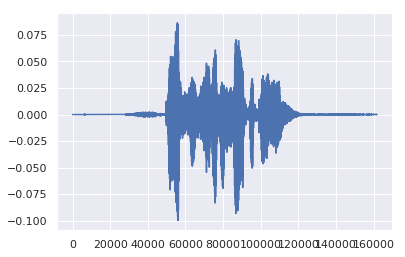

In [0]:
plt.figure()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([1, 201, 809])


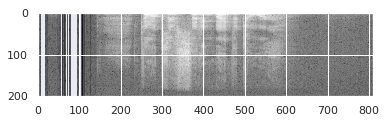

In [0]:
specgram = torchaudio.transforms.Spectrogram()(waveform)
print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

#Explore Video Data

In [0]:
ravdess_video_song_dir = os.listdir('/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/VIDEO/SONG')
ravdess_video_speech_dir = os.listdir('/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/VIDEO/SPEECH')

print("Video Song Actors: "+str(ravdess_video_song_dir))
print("Video Speech Actors: "+str(ravdess_video_speech_dir))

Video Song Actors: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
Video Speech Actors: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


vframes: torch.Size([139, 64, 64, 3]),  aframes: torch.Size([1, 0]),  info: {'video_fps': 29.0}
vframes: torch.Size([139, 64, 64, 3]),  aframes: torch.FloatTensor,  info: {'video_fps': 29.0}


<Figure size 432x288 with 0 Axes>

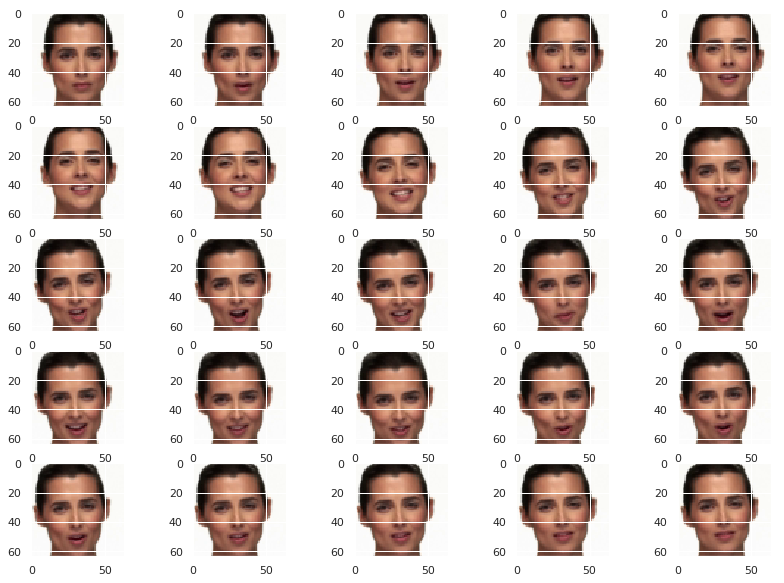

In [0]:
EXAMPLE_AUDIO_FILE_PATH = '/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/VIDEO/PROCESSED/SONG/Actor_12/01-02-02-02-01-02-12.mp4'

vframes, aframes, info = torchvision.io.read_video(EXAMPLE_AUDIO_FILE_PATH)

print("vframes: "+str(vframes.shape)+",  aframes: "+str(aframes.shape)+",  info: "+str(info))
print("vframes: "+str(vframes.shape)+",  aframes: "+str(aframes.type())+",  info: "+str(info))
plt.figure()

f, axarr = plt.subplots(5,5,figsize=(14, 10))
counter = 0
for i in range(5):
  for j in range(5):
    # print(vframes[counter].shape)
    # transform = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(),transforms.CenterCrop(512),transforms.Resize(64)])
    # pil_image = transform(vframes[counter].permute(2,0,1))
    axarr[i,j].imshow(vframes[counter])
    counter += 5

In [0]:
%%HTML
<video width="320" height="240"  controls>
  <source src='/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/VIDEO/SONG/Actor_12/01-02-06-01-02-01-12.mp4' type="video/mp4">
</video>

#Prepaere Data and Data Loaders

##Audio Data

In [0]:
class AudioDataset(Dataset):
    def __init__(self,base_dir_path):
      # Here we load the audio files and add them as tensors
      self.file_paths = []

      print("Creating Dataset from Files")
      ravdess_dir = os.listdir(base_dir_path)
      for vocal_cannel in ravdess_dir:
        vocal_cannel_dir = os.listdir(base_dir_path+'/'+vocal_cannel)
        for actor in vocal_cannel_dir:
          actor_dir = os.listdir(base_dir_path+'/'+vocal_cannel+'/'+actor)
          for file_name in actor_dir:
            label = int(file_name.split('-')[2])
            file_path = base_dir_path+'/'+vocal_cannel+'/'+actor+'/'+file_name
            self.file_paths.append((file_path,label))

    def __len__(self):
      return len(self.file_paths)

    def __getitem__(self, idx):
      file_path, label = self.file_paths[idx]
      waveform, sample_rate = torchaudio.load(file_path)
      specgram = torchaudio.transforms.Spectrogram()(waveform)
      specgram = specgram[:,:,390:400]
      # print(specgram.shape)
      return (specgram,label)

In [7]:
audio_dataset = AudioDataset('/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/AUDIO')

Creating Dataset from Files


In [8]:
len(audio_dataset)
audio_dataset[120][0].shape

torch.Size([1, 201, 10])

In [0]:
train_audio_dataloader = DataLoader(audio_dataset, batch_size=4, shuffle=True)

##Video Data

In [0]:
def preprocess_video_data(base_dir_path,frame_size=64,num_frames=6):
  print("Preprocessing Dataset in Drive")
  ravdess_dir = os.listdir(base_dir_path)
  for vocal_cannel in ravdess_dir:
    vocal_cannel_dir = os.listdir(base_dir_path+'/'+vocal_cannel)
    for actor in vocal_cannel_dir:
      actor_dir = os.listdir(base_dir_path+'/'+vocal_cannel+'/'+actor)
      for file_name in actor_dir:
        label = int(file_name.split('-')[2])
        file_path = base_dir_path+'/'+vocal_cannel+'/'+actor+'/'+file_name
        vframes, _, info = torchvision.io.read_video(file_path)
        vframes_tranformed = np.empty([len(vframes),frame_size,frame_size,3])
        frame_transforms = transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(512),transforms.Resize((frame_size,frame_size))])
        for i in range(len(vframes)):
          vframes_tranformed[i] = frame_transforms(vframes[i].permute(2,0,1))

       # Save new mp4 file
        processed_filename = base_dir_path+'/PROCESSED/'+vocal_cannel+'/'+actor+'/'+file_name
        fps =  int(info['video_fps'])
        torchvision.io.write_video(processed_filename, torch.Tensor(vframes_tranformed), fps)
      print(ctime().split()[3]+": Finished "+str(actor))

In [0]:
  base_dir_path = '/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/VIDEO'
  for vocal_cannel in ['SPEECH','SONG']:
    vocal_cannel_dir = os.listdir(base_dir_path+'/'+vocal_cannel)
    for actor in vocal_cannel_dir:
      actor_dir = base_dir_path+'/PROCESSED/'+vocal_cannel+'/'+actor
      try:
        os.mkdir(actor_dir)
      except:
        pass

In [0]:
# preprocess_video_data('/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/VIDEO')

In [0]:
class VideoDataset(Dataset):
    def __init__(self,base_dir_path,frame_size=64,num_frames=1):
      # Here we load the video files and add them as tensors
      self.file_paths = []
      self.frame_size = frame_size
      self.num_frames = num_frames

      print("Creating Dataset from Files")
      ravdess_dir = os.listdir(base_dir_path)
      for vocal_cannel in ravdess_dir:
        vocal_cannel_dir = os.listdir(base_dir_path+'/'+vocal_cannel)
        for actor in vocal_cannel_dir:
          actor_dir = os.listdir(base_dir_path+'/'+vocal_cannel+'/'+actor)
          for file_name in actor_dir:
            label = int(file_name.split('-')[2])
            flie_path = base_dir_path+'/'+vocal_cannel+'/'+actor+'/'+file_name
            # print(os.stat(flie_path).st_size)
            self.file_paths.append((flie_path,label))

    def __len__(self):
      return len(self.file_paths)

    def __getitem__(self, idx):
      # print("Started fetching item at: "+str(ctime()))
      file_path, label = self.file_paths[idx]
      vframes, _, _ = torchvision.io.read_video(file_path)
      vframes_tranformed = np.empty([1,len(vframes),self.frame_size,self.frame_size])
      frame_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(),transforms.ToTensor()])
      for i in range(len(vframes)):
        vframes_tranformed[:,i,:,:] = frame_transforms(vframes[i].permute(2, 0, 1))

      if self.num_frames==1:
        random_frame = random.randint(0, len(vframes)-1)
        vframes_tranformed[:,random_frame,:,:] = frame_transforms(vframes[random_frame].permute(2, 0, 1))
        item = (vframes_tranformed[:,random_frame,:,:], label-1)
      else:
        middle = len(vframes)//2
        start = middle - self.num_frames//2
        end = middle + self.num_frames//2
        for i in range(start,end):
          vframes_tranformed[:,i,:,:] = frame_transforms(vframes[i].permute(2, 0, 1))
        item = (vframes_tranformed[:,start:end,:,:], label-1)
      return item

In [0]:
video_dataset = VideoDataset('/content/drive/My Drive/Colab Notebooks/Research/RAVDESS/VIDEO/PROCESSED',num_frames=10)

Creating Dataset from Files


In [0]:
len(video_dataset)
print(video_dataset[3][0].shape)
# plt.imshow(video_dataset[120][0])

(1, 10, 64, 64)


In [0]:
video_train_size = int(0.8 * len(video_dataset))
video_test_size = len(video_dataset) - video_train_size
train_dataset, test_dataset = torch.utils.data.random_split(video_dataset, [video_train_size, video_test_size])

train_video_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_video_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
video_train_size

3923

##Model

In [0]:
class CNN3D(nn.Module):

    def __init__(self, use_dropout=False, use_batch_norm=True, channels_number=1, size=152, keep_prob=0.0):
        super(CNN3D, self).__init__()

        after_conv = ((size-10)//2-8)//2
        self.use_batch_norm = use_batch_norm

        self.conv1 = nn.Conv3d(in_channels=channels_number, out_channels=6, kernel_size=(5,5,5),stride=1, padding=(2,2,2))
        self.conv2 = nn.Conv3d(in_channels=6, out_channels=16, kernel_size=(3,3,3),stride=1, padding=(1,1,1))
        self.fc1 = nn.Linear(in_features = 21168, out_features = 120)
        self.batch_norm = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features =120,  out_features = 64)
        self.fc3 = nn.Linear(in_features =64,  out_features = 8)

    def forward(self, x):
        x = x.float()
        x = F.max_pool3d(F.relu(self.conv1(x)), (3,3,3))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        # print("I'm inlove with the shape of x: "+str(x.shape)+" after flattening")
        x = self.fc1(x)
        # print("I'm inlove with the shape of x: "+str(x.shape)+" after fc1")
        if self.use_batch_norm:
          x = self.batch_norm(x)
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
class CNN2D(nn.Module):

    def __init__(self, use_dropout=False, use_batch_norm=True, channels_number=1, size=152, keep_prob=0.0):
        super(CNN2D, self).__init__()

        after_conv = ((size-10)//2-8)//2
        self.use_batch_norm = use_batch_norm

        self.conv1 = nn.Conv2d(in_channels=channels_number, out_channels=6, kernel_size=(5,5),stride=1, padding=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(3,3),stride=1, padding=(1,1))
        self.fc1 = nn.Linear(in_features = 3216, out_features = 120)
        self.batch_norm = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features =120,  out_features = 64)
        self.fc3 = nn.Linear(in_features =64,  out_features = 8)

    def forward(self, x):
        x = x.float()
        x = F.max_pool2d(F.relu(self.conv1(x)), (3,3))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x))
        # print("I'm inlove with the shape of x: "+str(x.shape)+" after flattening")
        x = self.fc1(x)
        # print("I'm inlove with the shape of x: "+str(x.shape)+" after fc1")
        if self.use_batch_norm:
          x = self.batch_norm(x)
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
net = CNN3D(size=64).cuda()     # -- For GPU
print(net)

NameError: ignored

In [0]:
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
# training loop
def train(net, trainloader, optimizer, criterion, epochs=2):
  loss_array = []
  for epoch in range(epochs):  
    # torch.save(net.state_dict(), RAVDESS_DRIVE_DIR+'ravdess_3dcnn')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs

        # print("Data Loading starts at: "+str(ctime()))
        inputs, labels = data
        # print("Finished fetching "+str(len(inputs))+" items at: "+str(ctime()))

        inputs = inputs.cuda() # -- For GPU
        labels = labels.cuda() # -- For GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs.shape)
        # print("Forward starts at: "+str(ctime()))
        outputs = net(inputs)
        # print("Loss starts at: "+str(ctime()))
        loss = criterion(outputs, labels)
        # print("Backward starts at: "+str(ctime()))
        loss.backward()
        # print("Optimizer starts at: "+str(ctime()))
        optimizer.step()
        # print("Optimizer ends at: "+str(ctime()))

        # print statistics
        # print(loss.item())
        running_loss += loss.item()
        if (i % 200 == 0) and (i > 0):
          print('%s: [%d, %5d] loss: %.3f' % (ctime().split()[3], epoch, i, running_loss / 200))
          loss_array.append(running_loss / 200)
          running_loss = 0.0
        # print("Step ends at: "+str(ctime()+"\n"))
             
  print('Finished Training')
  return loss_array

In [13]:
torch.cuda.is_available()

True

In [0]:
`original_loss_array = []

In [0]:
original_loss_array.extend(train(net, train_video_dataloader))
save_obj(original_loss_array, 'ravdess_cnn')
torch.save(net.state_dict(), RAVDESS_DRIVE_DIR+'ravdess_3dcnn')

21:44:20: [0,   200] loss: 0.236
21:45:39: [0,   400] loss: 0.272
21:46:57: [0,   600] loss: 0.139
21:48:15: [0,   800] loss: 0.208
21:50:45: [1,   200] loss: 0.255
21:52:03: [1,   400] loss: 0.167
21:53:22: [1,   600] loss: 0.231
21:54:40: [1,   800] loss: 0.172
Finished Training


In [0]:
net.load_state_dict(torch.load(RAVDESS_DRIVE_DIR+'model'))
net.eval()

CNN3D(
  (conv1): Conv3d(1, 6, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv2): Conv3d(6, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=21168, out_features=120, bias=True)
  (batch_norm): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)

(120, 1)
(120, 1)


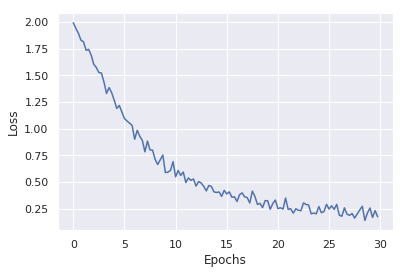

In [0]:
a = np.array(original_loss_array).reshape((len(original_loss_array),1))
print(a.shape)
b = np.array([float(i)/4 for i in range(len(original_loss_array))]).reshape((len(original_loss_array),1))
print(b.shape)

data = pd.DataFrame(np.concatenate((a,b),axis=1), columns = ["Loss","Epochs"])
# data.head()
ax = sns.lineplot(x="Epochs", y="Loss", data=data)

In [0]:
def evaluate(test_video_dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_video_dataloader:
      inputs, labels = data
      if inputs.shape[0] < 4:
        continue
      inputs, labels = inputs.cuda(), labels.cuda()
      
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  print('Accuracy of the network on the test images: %d %%' % (acc))
  return acc

In [0]:
# acc_array = []

In [0]:
acc = evaluate(test_video_dataloader)
acc = float('%.3f'%(acc))
acc_array.append(acc)
print(acc_array)

Accuracy of the network on the test images: 83 %
[37.551, 45.102, 58.061, 62.551, 66.531, 72.653, 73.878, 75.612, 80.102, 80.714, 81.735, 81.837, 79.898, 84.694, 83.878]


(15, 1)
(15, 1)


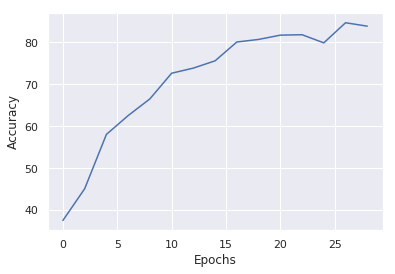

In [0]:
a = np.array(acc_array).reshape((len(acc_array),1))
print(a.shape)
b = np.array([float(i)*2 for i in range(len(acc_array))]).reshape((len(acc_array),1))
print(b.shape)

data = pd.DataFrame(np.concatenate((a,b),axis=1), columns = ["Accuracy","Epochs"])
# data.head()
ax = sns.lineplot(x="Epochs", y="Accuracy", data=data)

##Audio CNN


In [14]:
audio_net = CNN2D(size=64).cuda()     # -- For GPU
print(audio_net)

CNN2D(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3216, out_features=120, bias=True)
  (batch_norm): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)


In [0]:
audio_optimizer = torch.optim.Adam(audio_net.parameters())
audio_criterion = nn.CrossEntropyLoss()
audio_loss_array = []

In [19]:
audio_loss_array.extend(train(audio_net, train_audio_dataloader, audio_optimizer, audio_criterion))
save_obj(audio_loss_array, 'audio_loss_array')
torch.save(audio_net.state_dict(), RAVDESS_DRIVE_DIR+'audio_net')

RuntimeError: ignored